# 14a: Variational Inference with Normalizing Flows

**Solution:** [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kks32-courses/sciml/blob/main/lectures/14-normalizing-flows/14a-variational-inference-normalizing-flows.ipynb)

The idea is to approximate a complex multimodal probability density with a simple probability density followed by a sequence of invertible nonlinear transforms. Inference in such model requires a computation of multiple Jacobian determinants, that can be computationaly expensive. Authors propose a specific form of the transformation that reduces the cost of computing the Jacobians from approximately $O(d^3)$ to $O(d)$ where $d$ is the dimensionality of the data.

**Normalizing Flows** are a method for constructing complex distributions by transforming a
probability density through a series of invertible mappings. By repeatedly applying the rule for change of variables, the initial density ‘flows’ through the sequence of invertible mappings. At the end of this sequence we obtain a valid probability distribution and hence this type of flow is referred to as a normalizing flow.

In the case of finite flows, the basic rule for the transformation of densities considers an invertible, smooth mapping $f : \mathbb{R}^{d} \rightarrow \mathbb{R}^{d}$ with inverse $f^{-1} = g$, i.e. the composition $g \cdot f\left(z\right) = z$. If we use this mapping to transform a random variable $z$ with distribution $q\left(z\right)$, the resulting random variable $z' = f\left(z\right)$ has a distribution:

$$ q\left(\mathbf{z}'\right) = q\left(\mathbf{z}\right)\bigl\vert{\text{det}}\frac{\delta{f}^{-1}}{\delta{\mathbf{z'}}}\bigr\vert = q\left(\mathbf{z}\right)\bigl\vert{\text{det}}\frac{\delta{f}}{\delta{\mathbf{z}}}\bigr\vert ^{-1} $$

where the last equality can be seen by applying the chain rule (inverse function theorem) and is a property of Jacobians of invertible functions. We can construct arbitrarily complex densities by composing several simple maps and successively applying the above equation. The density $q\_{K}\left(\mathbf{z}\right)$ obtained by successively transforming a random variable $z\_{0}$ with distribution $q\_{0}$ through a chain of $K$ transformations $f\_{k}$ is:

$$ z\_{K} = f\_{K} \cdot \dots \cdot f\_{2} \cdot f\_{1}\left(z\_{0}\right) $$

$$ \ln{q}\_{K}\left(z\_{K}\right) = \ln{q}\_{0}\left(z\_{0}\right) − \sum^{K}\_{k=1}\ln\vert\det\frac{\delta{f\_{k}}}{\delta{\mathbf{z\_{k-1}}}}\vert $$

The path traversed by the random variables $z\_{k} = f\_{k}\left(z\_{k-1}\right)$ with initial distribution $q\_{0}\left(z\_{0}\right)$ is called the flow and the path formed by the successive distributions $q\_{k}$ is a normalizing flow.

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim

import os
import numpy as np
from matplotlib import pyplot as plt

Defines the target density that the normalizing flow model aims to approximate. This function takes a tensor $z$ and computes its density.

In [ ]:
# Densities
def p_z(z):
    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)

    return torch.exp(-u)

In [ ]:
# utils
def safe_log(z):
    return torch.log(z + 1e-7)


def random_normal_samples(n, dim=2):
    return torch.zeros(n, dim).normal_(mean=0, std=1)

A class representing the free energy bound, which computes the loss for the flow model using the sum of log Jacobians and the target density.

In [ ]:
class FreeEnergyBound(nn.Module):

    def __init__(self, density):
        super().__init__()

        self.density = density

    def forward(self, zk, log_jacobians):

        sum_of_log_jacobians = sum(log_jacobians)
        return (-sum_of_log_jacobians - safe_log(self.density(zk))).mean()


This class defines the normalizing flow model. It creates a sequence of transformations (PlanarFlow) and their respective log-Jacobian determinants (PlanarFlowLogDetJacobian). The forward method applies these transformations to input data.

In [ ]:
class NormalizingFlow(nn.Module):

    def __init__(self, dim, flow_length):
        super().__init__()

        self.transforms = nn.Sequential(*(
            PlanarFlow(dim) for _ in range(flow_length)
        ))

        self.log_jacobians = nn.Sequential(*(
            PlanarFlowLogDetJacobian(t) for t in self.transforms
        ))

    def forward(self, z):

        log_jacobians = []

        for transform, log_jacobian in zip(self.transforms, self.log_jacobians):
            log_jacobians.append(log_jacobian(z))
            z = transform(z)

        zk = z

        return zk, log_jacobians

# A module that represents an individual planar flow transformation.
# It defines parameters like weight, bias, and scale and applies the
# transformation to the input data.

class PlanarFlow(nn.Module):

    def __init__(self, dim):
        super().__init__()

        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.tanh = nn.Tanh()

        self.reset_parameters()

    def reset_parameters(self):

        self.weight.data.uniform_(-0.01, 0.01)
        self.scale.data.uniform_(-0.01, 0.01)
        self.bias.data.uniform_(-0.01, 0.01)

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.tanh(activation)

#  calculates the logarithm of the absolute value of the Jacobian determinant
# for the planar flow transformation, which is crucial for computing the change
# in density under the transformation.

class PlanarFlowLogDetJacobian(nn.Module):
    """A helper class to compute the determinant of the gradient of
    the planar flow transformation."""

    def __init__(self, affine):
        super().__init__()

        self.weight = affine.weight
        self.bias = affine.bias
        self.scale = affine.scale
        self.tanh = affine.tanh

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        psi = (1 - self.tanh(activation) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return safe_log(det_grad.abs())


Plot functions

In [ ]:
def scatter_points(points, directory, iteration, flow_length):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)
    ax.set_title(
        "Flow length: {}\n Samples on iteration #{}"
        .format(flow_length, iteration)
    )

    fig.savefig(os.path.join(directory, "flow_result_{}.png".format(iteration)))
    plt.close()


def plot_density(density, directory):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    x1 = np.linspace(*X_LIMS, 300)
    x2 = np.linspace(*Y_LIMS, 300)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1 = x1.ravel()
    x2 = x2.ravel()

    z = np.c_[x1, x2]
    z = torch.FloatTensor(z)
    z = Variable(z)

    density_values = density(z).data.numpy().reshape(shape)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.imshow(density_values, extent=(*X_LIMS, *Y_LIMS), cmap="summer")
    ax.set_title("True density")

    fig.savefig(os.path.join(directory, "density.png"))
    plt.close()

In [ ]:
# Set the seed for reproducibility
torch.manual_seed(42)

# Configuration
config = {
    "batch_size": 40,
    "iterations": 10000,
    "initial_lr": 0.01,
    "lr_decay": 0.999,
    "flow_length": 16,
}

# Create directories for saving samples and distributions
os.makedirs("samples", exist_ok=True)
os.makedirs("distributions", exist_ok=True)

# Initialize your model and optimizer here
flow = NormalizingFlow(dim=2, flow_length=config['flow_length'])
bound = FreeEnergyBound(density=p_z)
optimizer = optim.RMSprop(flow.parameters(), lr=config['initial_lr'])
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, config['lr_decay'])

# Plot the density - Implement the plot_density function as per your requirement
plot_density(p_z, directory="distributions")

def should_log(iteration):
    return iteration % 300 == 0

def should_plot(iteration):
    return iteration % 300 == 0

# Training loop
for iteration in range(1, config['iterations'] + 1):

    samples = Variable(random_normal_samples(config['batch_size']))
    zk, log_jacobians = flow(samples)

    optimizer.zero_grad()
    loss = bound(zk, log_jacobians)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if should_log(iteration):
        print(f"Loss on iteration {iteration}: {loss.item()}")

    if should_plot(iteration):
        samples = Variable(random_normal_samples(1000))
        zk, det_grads = flow(samples)
        scatter_points(
            zk.data.numpy(),
            directory="samples",
            iteration=iteration,
            flow_length=config['flow_length']
        )

Loss on iteration 300: 0.5367072224617004
Loss on iteration 600: 0.7246438264846802
Loss on iteration 900: 1.107620120048523
Loss on iteration 1200: 0.7232418060302734
Loss on iteration 1500: 0.6367783546447754
Loss on iteration 1800: 0.8605233430862427
Loss on iteration 2100: 0.6706315875053406
Loss on iteration 2400: 0.6784031987190247
Loss on iteration 2700: 0.6142565011978149
Loss on iteration 3000: 0.4677770733833313
Loss on iteration 3300: 0.7237043976783752
Loss on iteration 3600: 0.5454834699630737
Loss on iteration 3900: 0.35454675555229187
Loss on iteration 4200: 0.834605872631073
Loss on iteration 4500: 0.43641749024391174
Loss on iteration 4800: 0.3652383089065552
Loss on iteration 5100: 0.4191502630710602
Loss on iteration 5400: 0.4390262961387634
Loss on iteration 5700: 0.44274425506591797
Loss on iteration 6000: 0.4874604344367981
Loss on iteration 6300: 0.2948246896266937
Loss on iteration 6600: 0.6251242756843567
Loss on iteration 6900: 0.8705251812934875
Loss on itera

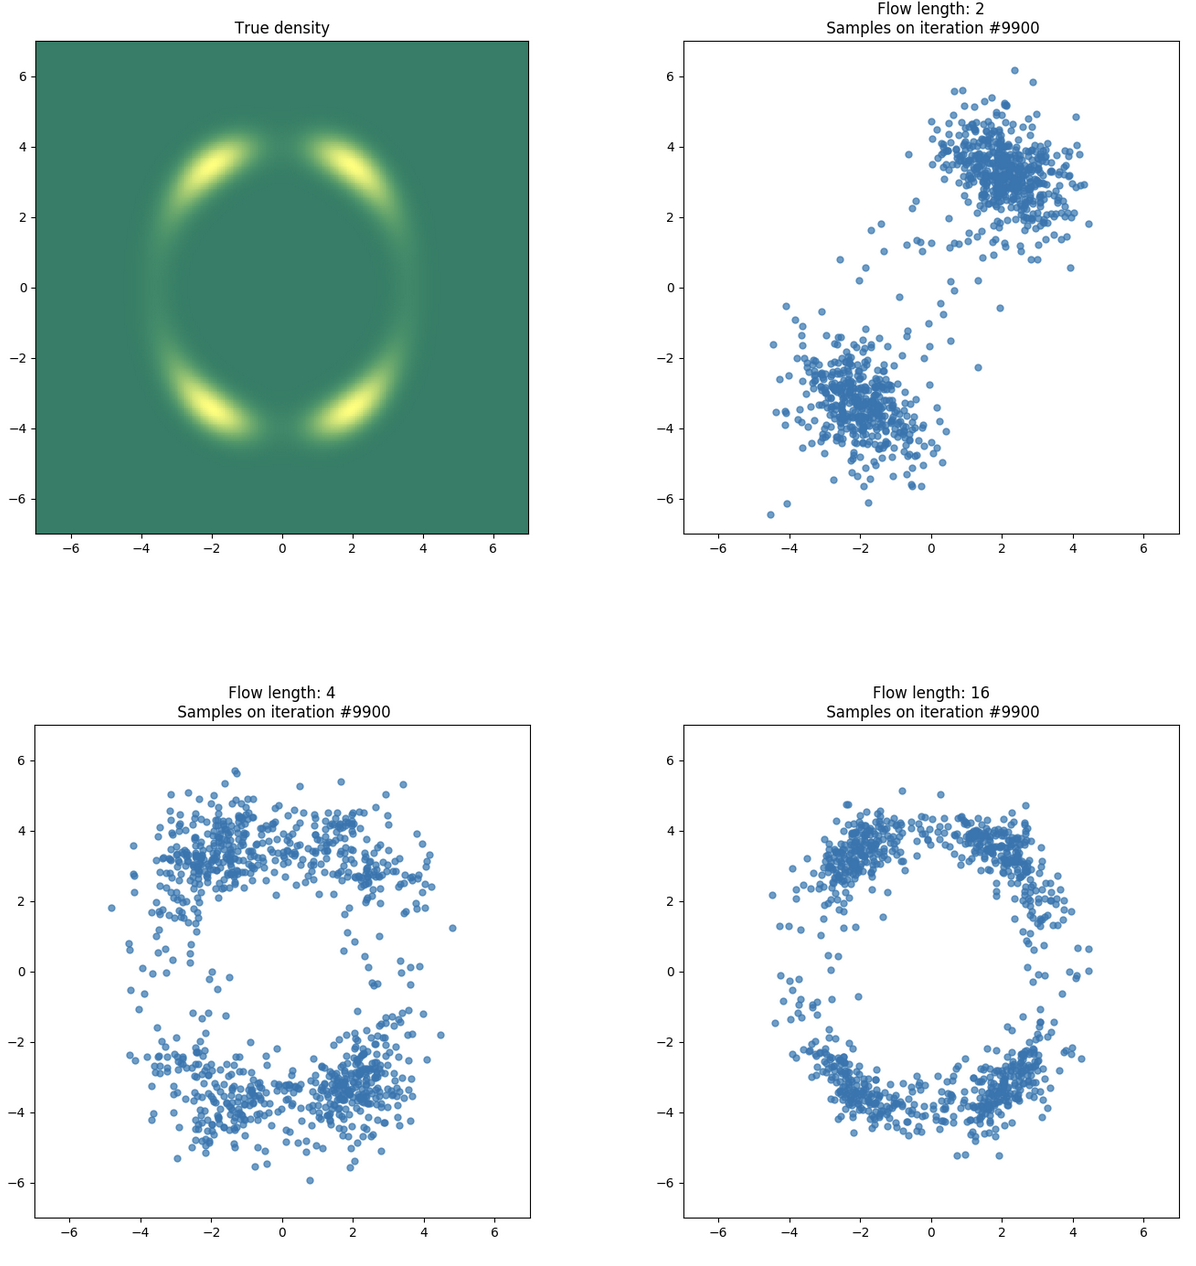